In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [63]:
df = pd.read_csv('datasets/output_1_roberta.csv', encoding='utf8')

In [64]:
# Create list to store reorganized rows
reorganized_data = []

def normalize_label(label):
    """Convert various label formats to 'human' or 'ai'"""
    if pd.isna(label):
        return None
    label_lower = str(label).lower().strip()
    if 'human' in label_lower:
        return 'human'
    elif 'ai' in label_lower or 'generated' in label_lower:
        return 'ai'
    return None

# Group by question to handle duplicates
for question in df['question'].unique():
    question_data = df[df['question'] == question]
    
    # Human answer (first row, no prompt)
    human_row = question_data.iloc[0]
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['answer'],
        'prompt': '',
        'true_label': 'human',
        'predicted_label': normalize_label(human_row['answer_detection_prediction'])
    })
    
    # Regular AI answer (first row's AI answer, no prompt)
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['question_answer_ai'],
        'prompt': '',
        'true_label': 'ai',
        'predicted_label': normalize_label(human_row['question_answer_ai_detection_prediction'])
    })
    
    # Prompted AI answers (one for each unique prompt)
    for _, row in question_data.iterrows():
        if pd.notna(row['prompt']) and row['prompt'] != '':
            reorganized_data.append({
                'question': row['question'],
                'answer': row['question_with_prompt_answer_ai'],
                'prompt': row['prompt'],
                'true_label': 'ai',
                'predicted_label': normalize_label(row['question_with_prompt_answer_ai_detection_prediction'])
            })

# Create new dataframe
df_clean = pd.DataFrame(reorganized_data)

print(f"Original rows: {len(df)}")
print(f"Reorganized rows: {len(df_clean)}")
print("\nValue counts for true_label:")
print(df_clean['true_label'].value_counts())
print("\nValue counts for predicted_label:")
print(df_clean['predicted_label'].value_counts())
print("\nThe Dataframe itself:")
df_clean

Original rows: 5
Reorganized rows: 7

Value counts for true_label:
true_label
ai       6
human    1
Name: count, dtype: int64

Value counts for predicted_label:
predicted_label
ai       6
human    1
Name: count, dtype: int64

The Dataframe itself:


,question,answer,prompt,true_label,predicted_label
0,You 've finally managed to discover the secret...,"So many times have I walked on ruins, the rema...",,human,ai
1,You 've finally managed to discover the secret...,7,,ai,human
2,You 've finally managed to discover the secret...,"1 ) You 're a clever one , aren 't you , Death...",Write like a human.,ai,ai
3,You 've finally managed to discover the secret...,1 ) I want to start by saying how deeply I adm...,"I’m writing to someone I really respect, can y...",ai,ai
4,You 've finally managed to discover the secret...,"1 ) I stood there in stunned silence , the wei...","Add a touch of humor, but keep it real.",ai,ai
5,You 've finally managed to discover the secret...,You 've finally figured out the secret to livi...,Can you make this sound a bit more natural?,ai,ai
6,You 've finally managed to discover the secret...,"1. Death 's business card reads , "" Death - Th...",Do not allow the text to be detected as AI-wri...,ai,ai


In [65]:
human_answers = df_clean[df_clean['true_label'] == 'human']
regular_ai = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == '')]

# Get individual prompts
unique_prompts = df_clean[df_clean['prompt'] != '']['prompt'].unique()

# Create groups dictionary with human and regular AI
groups = {
    'Human Answers': human_answers,
    'Regular AI (No Prompt)': regular_ai,
}

# Add each prompt as a separate group
for prompt in unique_prompts:
    prompt_df = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == prompt)]
    groups[f'{prompt}'] = prompt_df

# Prepare a list to store results
results = []

for group_name, group_df in groups.items():
    if len(group_df) > 0:
        # Calculate accuracy
        correct = (group_df['true_label'] == group_df['predicted_label']).sum()
        accuracy = correct / len(group_df)

        # Confusion matrix values
        true_labels = group_df['true_label']
        pred_labels = group_df['predicted_label']

        tp = ((true_labels == 'human') & (pred_labels == 'human')).sum()
        fn = ((true_labels == 'human') & (pred_labels == 'ai')).sum()
        fp = ((true_labels == 'ai') & (pred_labels == 'human')).sum()
        tn = ((true_labels == 'ai') & (pred_labels == 'ai')).sum()

        # Calculate specific metrics
        if group_df['true_label'].iloc[0] == 'human':
            correct_human = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Positives (Human)': tp,
                'False Negatives (Human as AI)': fn,
                'Correctly Identified as Human': correct_human,
            })
        else:
            correct_ai = (group_df['predicted_label'] == 'ai').sum()
            fooled = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Negatives (AI)': tn,
                'False Positives (AI as Human)': fp,
                'Correctly Identified as AI': correct_ai,
                'Fooled Detector (Predicted as Human)': fooled,
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Calculate overall accuracy
overall_correct = (df_clean['true_label'] == df_clean['predicted_label']).sum()
overall_accuracy = overall_correct / len(df_clean)

# Add overall accuracy to DataFrame
overall_row = {
    'Group': 'Overall',
    'Sample Size': len(df_clean),
    'Accuracy': overall_accuracy,
}
results_df = pd.concat([results_df, pd.DataFrame([overall_row])], ignore_index=True)

# Compare prompted vs unprompted AI (aggregate all prompts)
prompted_ai_all = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] != '')]
if len(regular_ai) > 0 and len(prompted_ai_all) > 0:
    regular_detected = (regular_ai['predicted_label'] == 'ai').sum() / len(regular_ai)
    prompted_detected = (prompted_ai_all['predicted_label'] == 'ai').sum() / len(prompted_ai_all)
    reduction = regular_detected - prompted_detected
    improvement_pct = ((reduction) / regular_detected * 100) if regular_detected > 0 else 0

    prompt_effect_row = {
        'Group': 'Prompt Effectiveness (Aggregate)',
        'Regular AI Detected as AI': f"{regular_detected:.2%}",
        'Prompted AI Detected as AI': f"{prompted_detected:.2%}",
        'Reduction in Detection Rate': f"{reduction:.2%}",
        'Prompts Improved Evasion by': f"{improvement_pct:.1f}%",
    }
    prompt_effect_df = pd.DataFrame([prompt_effect_row])

# Display the DataFrames
print("Accuracy and Confusion Matrix Results:")
print(results_df[['Group', 'Sample Size', 'Accuracy']].to_string(index=False))

print("\nPrompt Effectiveness Analysis:")
print(prompt_effect_df.to_string(index=False))

Accuracy and Confusion Matrix Results:
                                                                  Group  Sample Size  Accuracy
                                                          Human Answers            1  0.000000
                                                 Regular AI (No Prompt)            1  0.000000
                                                    Write like a human.            1  1.000000
I’m writing to someone I really respect, can you help me sound genuine?            1  1.000000
                                Add a touch of humor, but keep it real.            1  1.000000
                            Can you make this sound a bit more natural?            1  1.000000
                    Do not allow the text to be detected as AI-written.            1  1.000000
                                                                Overall            7  0.714286

Prompt Effectiveness Analysis:
                           Group Regular AI Detected as AI Prompted AI Det

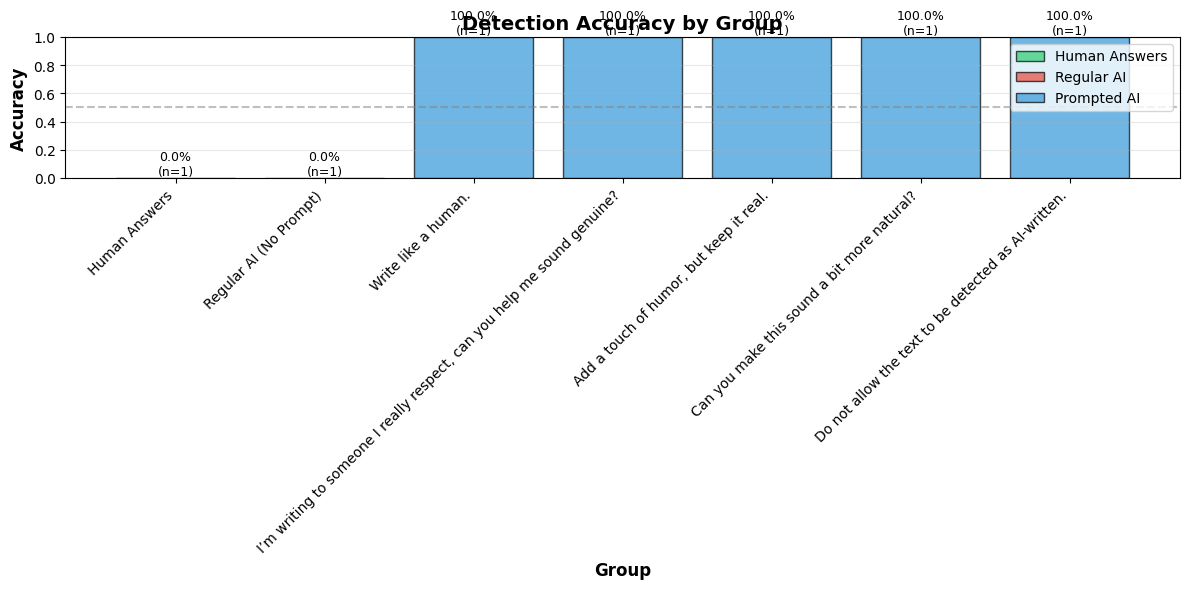

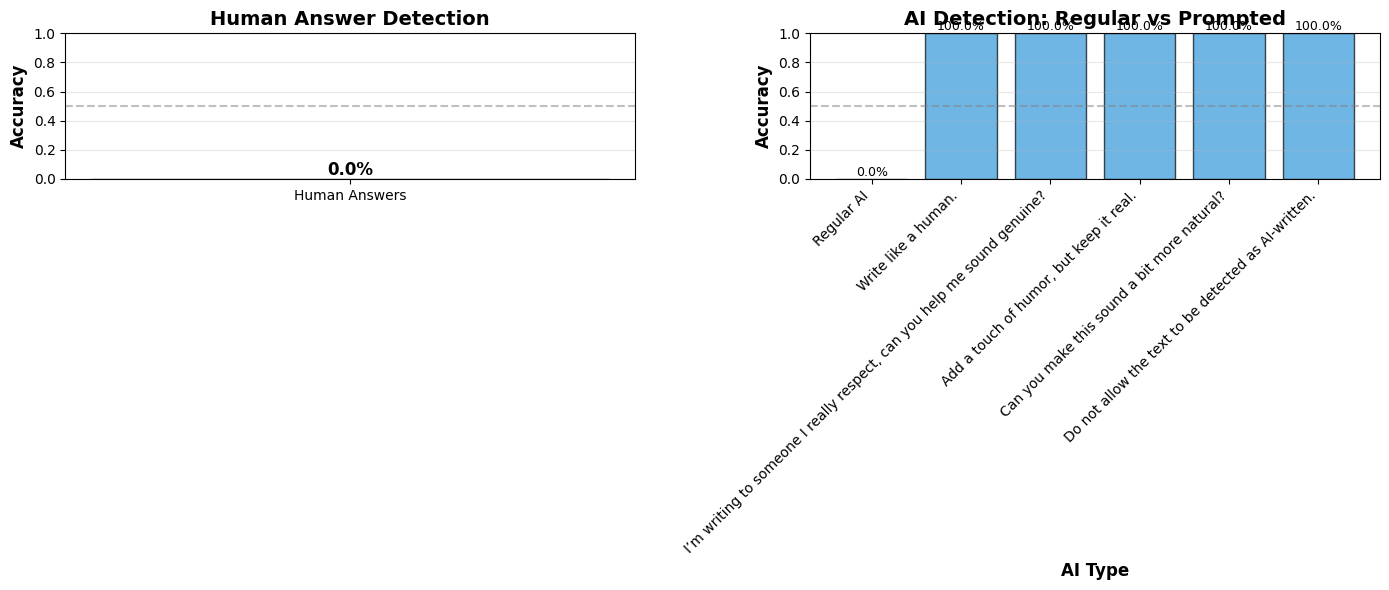


Overall Detection Accuracy: 71.43%


In [66]:
# Filter out the 'Overall' row for the main visualization
results_plot = results_df[results_df['Group'] != 'Overall'].copy()

# Extract data for plotting
groups = results_plot['Group'].tolist()
accuracies = results_plot['Accuracy'].tolist()
sample_sizes = results_plot['Sample Size'].tolist()

# Create color mapping
colors = []
for group in groups:
    if 'Human' in group:
        colors.append('#2ecc71')  # Green for human
    elif 'Regular AI' in group:
        colors.append('#e74c3c')  # Red for regular AI
    else:
        colors.append('#3498db')  # Blue for prompted AI

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar chart
bars = ax.bar(range(len(groups)), accuracies, color=colors, alpha=0.7, edgecolor='black')

# Customize the plot
ax.set_xlabel('Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Detection Accuracy by Group', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline (50%)')
ax.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, (bar, acc, size) in enumerate(zip(bars, accuracies, sample_sizes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}\n(n={size})',
            ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, edgecolor='black', label='Human Answers'),
    Patch(facecolor='#e74c3c', alpha=0.7, edgecolor='black', label='Regular AI'),
    Patch(facecolor='#3498db', alpha=0.7, edgecolor='black', label='Prompted AI')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Create a second visualization: Comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Human vs AI detection rates
human_data = results_plot[results_plot['Group'].str.contains('Human')]
ai_data = results_plot[~results_plot['Group'].str.contains('Human')]

if len(human_data) > 0:
    human_acc = human_data['Accuracy'].iloc[0]
    ax1.bar(['Human Answers'], [human_acc], color='#2ecc71', alpha=0.7, edgecolor='black')
    ax1.text(0, human_acc, f'{human_acc:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Human Answer Detection', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# Right plot: Regular AI vs Prompted AI
ai_groups = ai_data['Group'].tolist()
ai_accuracies = ai_data['Accuracy'].tolist()
ai_colors = ['#e74c3c' if 'Regular' in g else '#3498db' for g in ai_groups]

bars2 = ax2.bar(range(len(ai_groups)), ai_accuracies, color=ai_colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('AI Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('AI Detection: Regular vs Prompted', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(ai_groups)))

# Shorten labels for better display
short_labels = []
for g in ai_groups:
    if 'Regular' in g:
        short_labels.append('Regular AI')
    else:
        # Extract just the prompt part
        short_labels.append(g.replace('Prompt: ', ''))
        
ax2.set_xticklabels(short_labels, rotation=45, ha='right')
ax2.set_ylim(0, 1.0)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars2, ai_accuracies)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1%}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print overall accuracy
overall_row = results_df[results_df['Group'] == 'Overall']
if len(overall_row) > 0:
    overall_acc = overall_row['Accuracy'].iloc[0]
    print(f"\nOverall Detection Accuracy: {overall_acc:.2%}")